# 1. Load Dataset

In [1]:
# load packages and libraries
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.feature_extraction.text
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.dummy
from sklearn.dummy import DummyClassifier
%matplotlib inline

In [2]:
# in case the data is in sqlite db ,accessing same through python
# conn = sqlite3.connect('database.sqlite')
# c = conn.cursor()
# df1=pd.read_sql("""select * from Reviews""",con=conn)

In [3]:
#loading data from csv file
df=pd.read_csv('Reviews.csv')

# 2. Data QC and Processing

In [4]:
df.sample().T

,60139
Id,60140
ProductId,B000EDG598
UserId,A2LYRRWF5UZ2WO
ProfileName,"Jirka ""Two Little Chicks"""
HelpfulnessNumerator,24
HelpfulnessDenominator,25
Score,5
Time,1149206400
Summary,Fry that chicken!
Text,This is wonderful on chicken! I use this prod...


In [5]:
df.shape

(568454, 10)

In [6]:
df.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295743
Text                      393579
dtype: int64

In [7]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [8]:
df.fillna('',inplace=True)

In [9]:
#collinearity between columns
df.corr()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
Id,1.000000,0.001227,0.000770,0.010706,0.007912
HelpfulnessNumerator,0.001227,1.000000,0.974689,-0.032590,-0.154818
HelpfulnessDenominator,0.000770,0.974689,1.000000,-0.097986,-0.173289
Score,0.010706,-0.032590,-0.097986,1.000000,-0.062760
Time,0.007912,-0.154818,-0.173289,-0.062760,1.000000


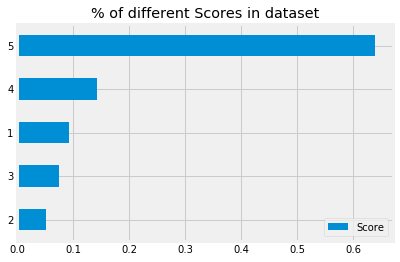

In [10]:
# % of different Score in dataset
df.Score.value_counts(normalize=True).sort_values(ascending=True).plot(
    kind='barh',legend=True,title='% of different Scores in dataset')

In [11]:
#converting column Time to correct timeformat
df['datetime'] = df['Time'].map(lambda x: (datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')))
df['datetime'] = pd.to_datetime(df['datetime'])

In [12]:
df.sort_values(by='datetime',inplace=True)

In [13]:
# returns columns with object time 
df.select_dtypes(exclude=['int64']).columns

Index([u'ProductId', u'UserId', u'ProfileName', u'Summary', u'Text',
       u'datetime'],
      dtype='object')

In [14]:
for col in ['ProductId', 'UserId', 'ProfileName', 'Summary', 'Text']:
    df[col] = df[col].astype('category')

In [15]:
#converting 5-class Score column to binary i.e good/bad
df['Score_cat']=np.where(df['Score']>=4, 'good', 'bad')

In [16]:
df[df.Id==137921].T

,137920
Id,137921
ProductId,B0032GA608
UserId,A2WFX1JQOAN659
ProfileName,lady gogo
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,5
Time,1348617600
Summary,Beautiful
Text,The beans arrived in plenty of time for planti...


# Descriptive and Inferential statistics

In [17]:
# generating descriptive statistics about the numeric columns
df[['HelpfulnessNumerator','HelpfulnessDenominator','Score']].describe().T

,count,mean,std,min,25%,50%,75%,max
HelpfulnessNumerator,568454.0,1.743817,7.636513,0.0,0.0,0.0,2.0,866.0
HelpfulnessDenominator,568454.0,2.228810,8.289740,0.0,0.0,1.0,2.0,923.0
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


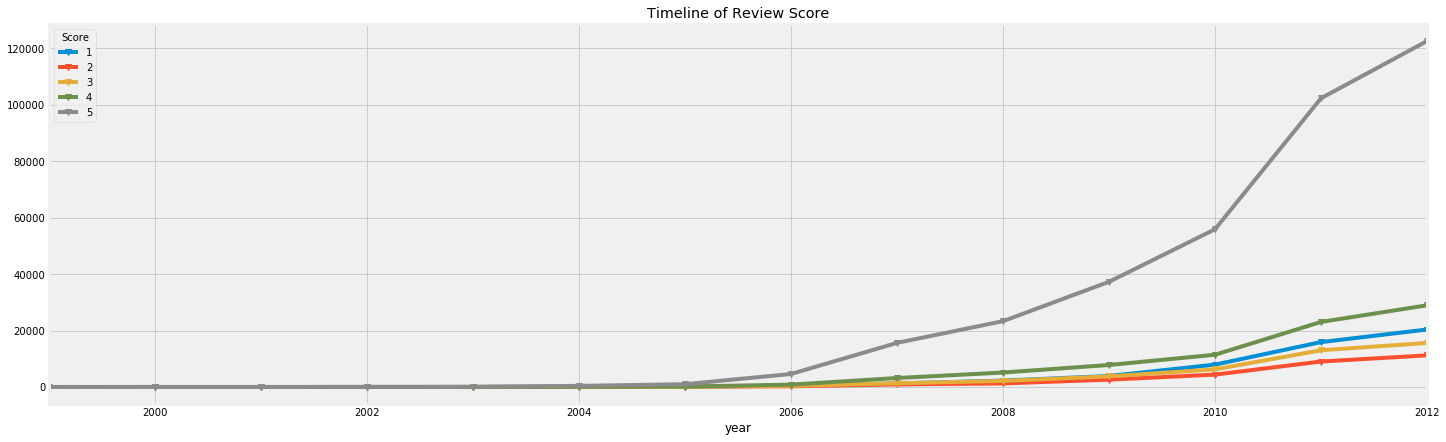

In [18]:
df['year']=df.datetime.dt.year
df.groupby(['year','Score'])['Score'].count().unstack().plot(style='-v',figsize=(
    22,7),title='Timeline of Review Score')

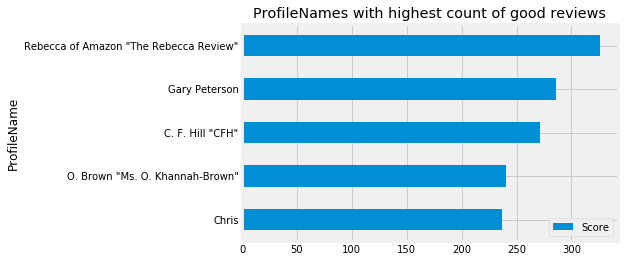

In [19]:
#Profiles which gave most Score 1
df[df.Score==5].groupby('ProfileName')['Score'].count().nlargest(5).sort_values(
    ascending=True).plot(kind='barh',legend=True,title='ProfileNames with highest count of good reviews')

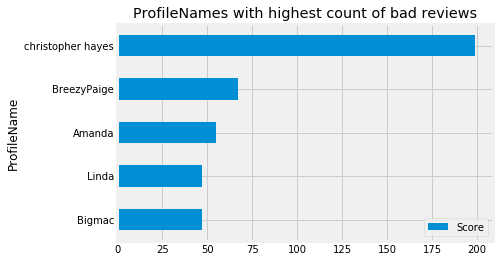

In [20]:
#Profiles which gave most Score 1
df[df.Score==1].groupby('ProfileName')['Score'].count().nlargest(5).sort_values(
    ascending=True).plot(kind='barh',legend=True,title='ProfileNames with highest count of bad reviews')

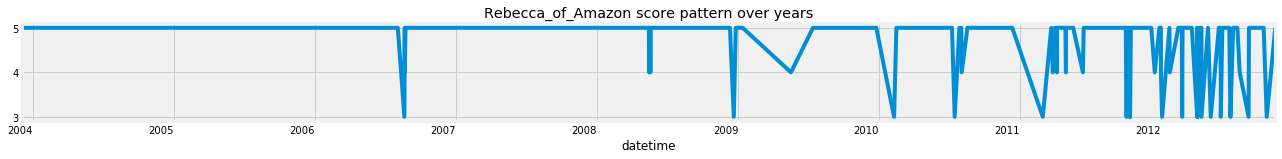

In [21]:
df[df.ProfileName.str.contains('Rebecca of')].set_index('datetime').Score.plot(figsize=(
    20,2),rot=0,title='Rebecca_of_Amazon score pattern over years')

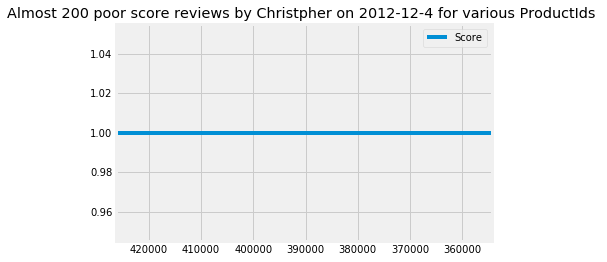

In [22]:
#Review time line of Peoplename 'Anonymous'
df[df.ProfileName.str.contains('christopher hayes')][['datetime','Score']].plot(
    title='Almost 200 poor score reviews by Christpher on 2012-12-4 for various ProductIds ')

# NLP
Treating it as a classfication problen to classify whether a review is good or bad based on text in Summary column

In [23]:
#5-Class(1-5)model
df_tfidf = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,3))
df_x = df_tfidf.fit_transform(df.Summary)
df_y = df.Score

In [24]:
seed = 7
clfs = []
params = {'n_neighbors' : [1,10]}
clfs.append(('Dummy',DummyClassifier(strategy='most_frequent')))
clfs.append(('LR', LogisticRegression()))
results = []
names = []
scoring = 'accuracy'

Dummy: 0.638789 (0.025524)
LR: 0.719077 (0.014433)


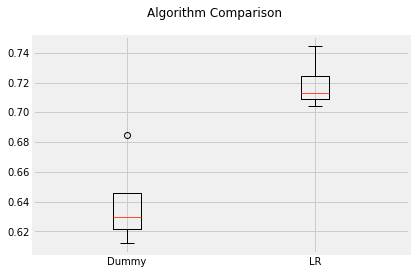

In [25]:
for name, model in clfs:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, df_x, df_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [31]:
#2-class(good-bad) model
df_y_1 = df.Score_cat

Dummy: 0.780674 (0.024695)
LR: 0.895422 (0.007076)


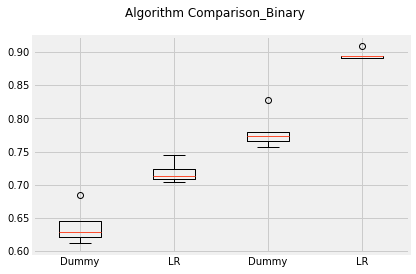

In [27]:
for name, model in clfs:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, df_x, df_y_1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison_Binary')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()